# 过拟合、欠拟合及其解决方案
- 过拟合、欠拟合的概念
- 权重衰减
- 丢弃法

## 训练误差和泛化误差
我们需要区分训练误差（training error）和泛化误差（generalization error）。通俗来讲，前者指模型在训练数据集上表现出的
误差，后者指模型在任意一个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似。机器学习模型应关注降低
泛化误差。

## 模型选择

### 验证数据集
预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。

### K折交叉验证
K折交叉验证（K-fold cross-validation），把原始训练数据集分割成K个不重合的子数据集，然后我们做K次模型训练和验证。每一次，
我们使用一个子数据集验证模型，并使用其他K-1个子数据集来训练模型。在这K次训练和验证中，每次用来验证模型的子数据集都不同。
最后，我们对这K次训练误差和验证误差分别求平均。

## 过拟合和欠拟合
- 一类是模型无法得到较低的训练误差，我们将这一现象称作欠拟合（underfitting）；
- 另一类是模型的训练误差远小于它在测试数据集上的误差，我们称该现象为过拟合（overfitting）。

### 模型复杂度
$$\hat y = b + \sum\limits_{k=1}^K x^k w_k$$
其中$x$数据特征，$y$是标签，$w_k$是权重参数，$b$是偏差参数。
![模型复杂度](../img/Snipaste_2020-02-15_11-45-50.png)

### 训练数据大小
影响欠拟合和过拟合的另一个重要因素是训练数据集的大小。一般来说，如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生。此外，泛化误差不会随训练数据集里样本数量增加而增大。因此，在计算资源允许的范围之内，我们通常希望训练数据集大一些，特别是在模型复杂度较高时，例如层数较多的深度学习模型。


## 多项式函数拟合实验

In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
import utils

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
         + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype = torch.float)

In [3]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.1427],
         [ 0.7880]]), tensor([[-0.1427,  0.0204, -0.0029],
         [ 0.7880,  0.6209,  0.4892]]), tensor([4.7243, 6.5822]))

## 定义、训练和测试

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
            legend=None, figsize=(3.5, 2.5)):
    utils.plt.xlabel(x_label)
    utils.plt.ylabel(y_label)
    utils.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        utils.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        utils.plt.legend(legend)

In [5]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    # 初始化网络模型
    net = torch.nn.Linear(train_features.shape[-1], 1)
    
    # 设置批量大小
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)   # 设置数据集
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)   # 设置获取数据的方式
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)  # 设置优化函数
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
        
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epoch', 'loss',
            range(1, num_epochs + 1), test_ls,['train', 'test'])
    print('weight:', net.weight.data,
         '\nbias:', net.bias.data)

### 三阶多项式函数拟合（正常）

final epoch: train loss 0.00014871679013594985 test loss 0.0006470357766374946
weight: tensor([[ 1.1894, -3.3944,  5.6051]]) 
bias: tensor([4.9947])


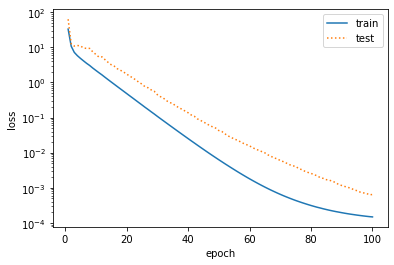

In [6]:
# 正常
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 59.15480422973633 test loss 233.05059814453125
weight: tensor([[12.5751]]) 
bias: tensor([1.1554])


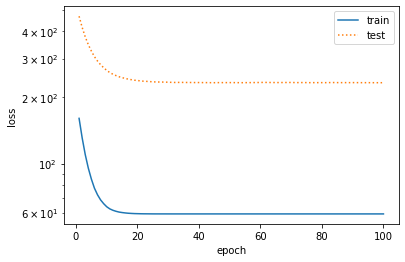

In [7]:
# 欠拟合
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 0.49693435430526733 test loss 309.7272644042969
weight: tensor([[1.6167, 1.5739, 0.7281]]) 
bias: tensor([3.9292])


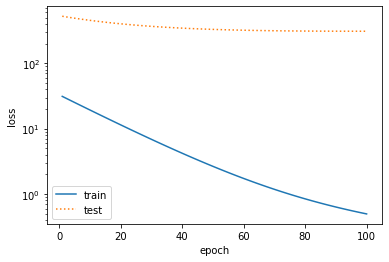

In [8]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

## 权重衰减
### 方法
#### L2正则
$$l(w_1, w_2, b) = \frac{1}{n}\sum\limits_{i=1}^n \frac{1}{2}(x_1^(i)w_1 + x_2^{i}w_2 + b - y^{(i)})^2$$

$$w_1 \gets (1- \frac{\eta \lambda}{|\beta|})w_1 - \frac{\eta}{|\beta|}\sum\limits_{i \epsilon \beta}x_1^{(i)}(x_1^{(1)}w_1 + x_2^{(i)}w_2 + b - y^{(i)}) $$
$$w_2 \gets (1- \frac{\eta \lambda}{|\beta|})w_2 - \frac{\eta}{|\beta|}\sum\limits_{i \epsilon \beta}x_1^{(i)}(x_1^{(1)}w_1 + x_2^{(i)}w_2 + b - y^{(i)}) $$

## 高维线性回归实验
$$y = 0.05 + \sum\limits_{i = 1}^p 0.01 x_i + \epsilon$$
其中$\epsilon$ 服从$mean = 0, std = 0.01$的正态分布

In [9]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
import utils

print(torch.__version__)

1.2.0


### 初始化模型参数

In [10]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [11]:
# 定义参数初始化函数，初始化模型参数并且附上梯度
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义L2范数惩罚项

In [12]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

### 定义训练和测试

In [13]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = utils.linreg, utils.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            utils.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    utils.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.12699031829834


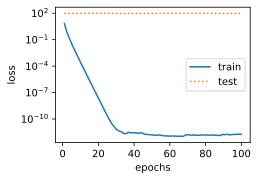

In [14]:
# 过拟合
fit_and_plot(lambd=0)

L2 norm of w: 0.03578969091176987


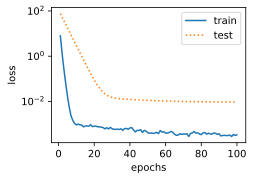

In [15]:
# 使用权重衰减
fit_and_plot(lambd=3)

In [16]:
# TODO pytorch 实现

## 丢弃法
MLB中，其中输入个数为4，隐藏单元个数为5，且隐藏单元$h_i(i = 1,\dots , 5)$的计算表达式为
$$h_i = \oint(x_1w_1 + x_2w_1 + x_3w_3 + x_4 w_4 + b_i) $$
使用丢弃法的新的隐藏单元$h_i'$
$$h_i' = \frac{\xi}{1-p}h_i$$
由于$E(\xi_i)=1 - p$,因此
$$E(h_i')=\frac{E(\xi_i)}{1-p}h_i$$

In [17]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
import utils

print(torch.__version__)

1.2.0


In [18]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    
    return mask * X / keep_prob

In [19]:
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [20]:
dropout(X, 0.5)

tensor([[ 0.,  2.,  4.,  6.,  8., 10., 12., 14.],
        [ 0., 18., 20.,  0.,  0.,  0.,  0., 30.]])

In [21]:
dropout(X, 1.0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [22]:
# 参数的初始化
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

In [23]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:  # 只在训练模型时使用丢弃法
        H1 = dropout(H1, drop_prob1)  # 在第一层全连接后添加丢弃层
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)  # 在第二层全连接后添加丢弃层
    return torch.matmul(H2, W3) + b3

In [24]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() # 改回训练模式
        else: # 自定义的模型
            if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                # 将is_training设置成False
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
        n += y.shape[0]
    return acc_sum / n

In [25]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, os.path.join(BASE_DIR))
print(BASE_DIR)

D:\Project\Anaconda


In [26]:
num_epochs, lr, batch_size = 5, 100.0, 256  # 这里的学习率设置的很大，原因与之前相同。
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = utils.load_data_fashion_mnist(batch_size, root=os.path.join(BASE_DIR,'dataset'))
utils.train_ch3(
    net,
    train_iter,
    test_iter,
    loss,
    num_epochs,
    batch_size,
    params,
    lr)

epoch 1, loss 0.0045, train acc 0.546, test acc 0.752
epoch 2, loss 0.0023, train acc 0.788, test acc 0.755
epoch 3, loss 0.0019, train acc 0.823, test acc 0.793
epoch 4, loss 0.0017, train acc 0.838, test acc 0.844
epoch 5, loss 0.0016, train acc 0.847, test acc 0.832
